In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Group & Topic info

Group members:
  - Florentin Dutruel 5011507
  - Adinda Ramadani 5347734
  - Watetu Mbugua 5721784
  - Aristi Molocha 5864755
  - Nguyen Thi Minh Hoa 5735041

Project type: Application Project<br>
Research Question: What is the correlation between vehicle kilometers and emissions?<br>
Sub question:
  - What are the trends of vehicle kilomiters over the years?
  - What are the trends of emissions over the years?
  - What are the correlations between e/vhkm and years?
  - What are the correlations between emissions and vhkm?

Scope:
  - Time: 1990-2021
  - Place: Netherlands
  - Vehicle types: Passenger cars & Road freight
  - Emission types: CO2, CO, NOx, PM10



<br><br>
Sources:
  - Emissions per transport mode 1990-2021: https://opendata.cbs.nl/statline/portal.html?_la=en&_catalog=CBS&tableId=84735ENG&_theme=1157 
  - Vehicle-kilometres for motor vehicles 1990-2020: https://opendata.cbs.nl/statline/portal.html?_la=en&_catalog=CBS&tableId=80302ENG


Contributions: https://docs.google.com/spreadsheets/d/13XAgn709_jYkHUsW45FdbP5MM8wKJRv-gXowcEMF_7Q/edit#gid=0

# Report

### Data import & filtering

Load the data from the two different datasets and link the data to the meta files.

In [7]:
vk_data = load_vk_data("data/vehicle-kilometres_data.csv", "data/vehicle-kilometres_typ_meta.csv")
ems_data = load_ems_data("data/emissions_data.csv", "data/emissions_source_meta.csv", "data/emissions_emission_meta.csv")

Filter and split the data sets into the used topics. 

In [15]:
vk_data_freight = getCategory(vk_data, "Vehicle Type", ["Delivery van", "Lorry (road tractor not included)", "Road tractor"], True)
vk_data_car = getCategory(vk_data, "Vehicle Type", ["Passenger car"], True)

ems_data = getCategory(ems_data, "Emission Type", ["Carbon dioxide (CO2)", "Carbon monoxide (CO)", "PM10 (Particulate matter)", "Nitrogen oxides (NOx)"], False)
ems_data_freight = getCategory(ems_data, "Sources", ["Road traffic, freight vehicles"], False)
ems_data_car = getCategory(ems_data, "Sources", ["Road traffic, passenger cars"], False)

Merge data sets and calculate emissions per kilomiter

In [9]:
freight_data = ems_data_freight.merge(right = vk_data_freight, how="left", on="Year")
car_data = ems_data_car.merge(right = vk_data_car, how="left", on="Year")

vehicle_data = pd.concat([freight_data, car_data])
vehicle_data["e/km"] = vehicle_data["Emission"] / vehicle_data["vhkm"]

display(vehicle_data)

,Sources,Emission Type,Year,Emission,vhkm,e/km
0,"Road traffic, freight vehicles",Carbon dioxide (CO2),1990,7.600000e+09,1.354200e+10,0.561217
1,"Road traffic, freight vehicles",Carbon dioxide (CO2),1991,7.900000e+09,1.436300e+10,0.550024
2,"Road traffic, freight vehicles",Carbon dioxide (CO2),1992,8.400000e+09,1.565000e+10,0.536741
3,"Road traffic, freight vehicles",Carbon dioxide (CO2),1993,8.500000e+09,1.657200e+10,0.512913
4,"Road traffic, freight vehicles",Carbon dioxide (CO2),1994,8.500000e+09,1.664700e+10,0.510603
...,...,...,...,...,...,...
123,"Road traffic, passenger cars",PM10 (Particulate matter),2017,2.300000e+06,1.089361e+11,0.000021
124,"Road traffic, passenger cars",PM10 (Particulate matter),2018,2.300000e+06,1.103559e+11,0.000021
125,"Road traffic, passenger cars",PM10 (Particulate matter),2019,2.200000e+06,1.103728e+11,0.000020
126,"Road traffic, passenger cars",PM10 (Particulate matter),2020,1.800000e+06,9.265420e+10,0.000019


### What are the trends of vehicle kilomiters over the years?

### What are the trends of emissions over the years?

### What are the correlations between e/vhkm and years?

### What are the correlations between emissions and vhkm?

### Conclusion & Discussion

# Graphs and stuff

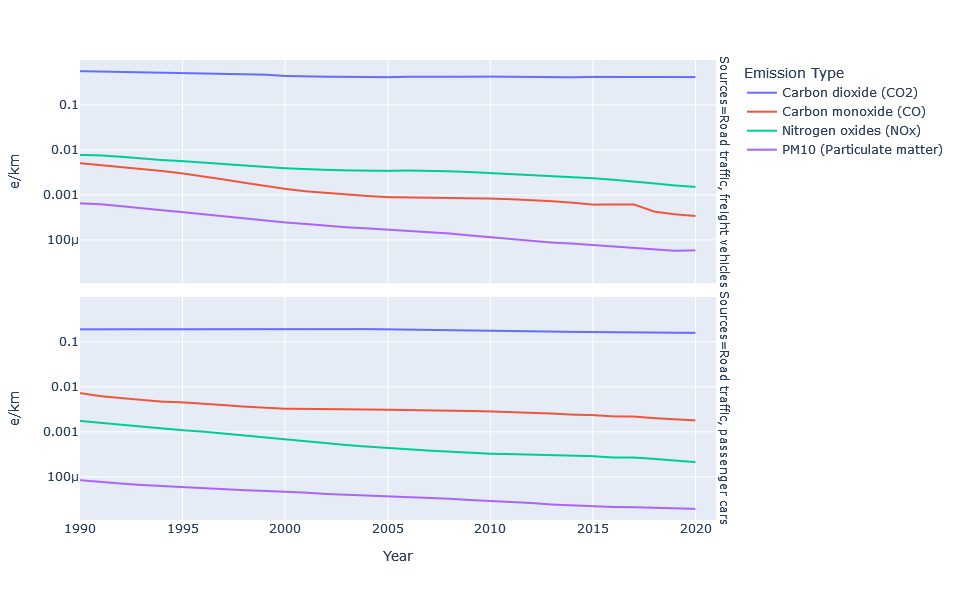

In [18]:
px.line(vehicle_data, x="Year", y="e/km", color="Emission Type", facet_row="Sources", log_y=True, height=600)

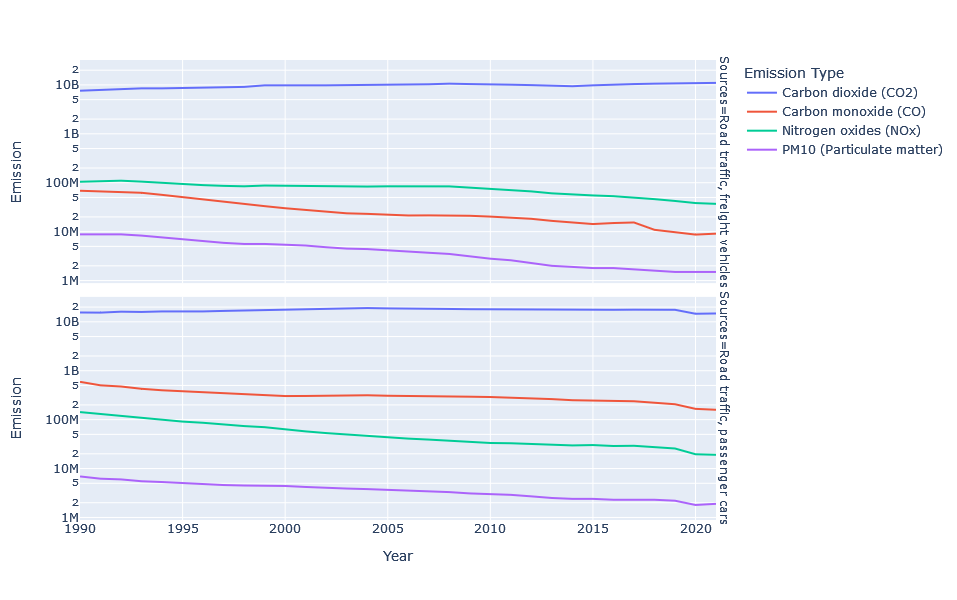

In [11]:
px.line(vehicle_data, x="Year", y="Emission", color="Emission Type", facet_row="Sources", log_y=True, height=600)

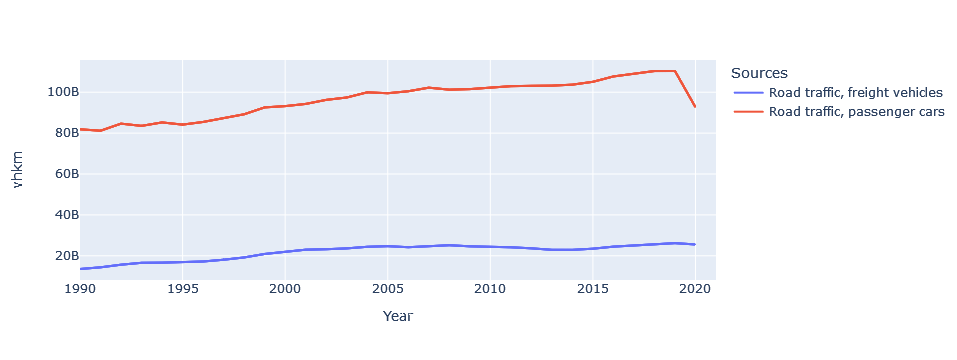

In [12]:
px.line(vehicle_data, x="Year", y="vhkm", color="Sources")

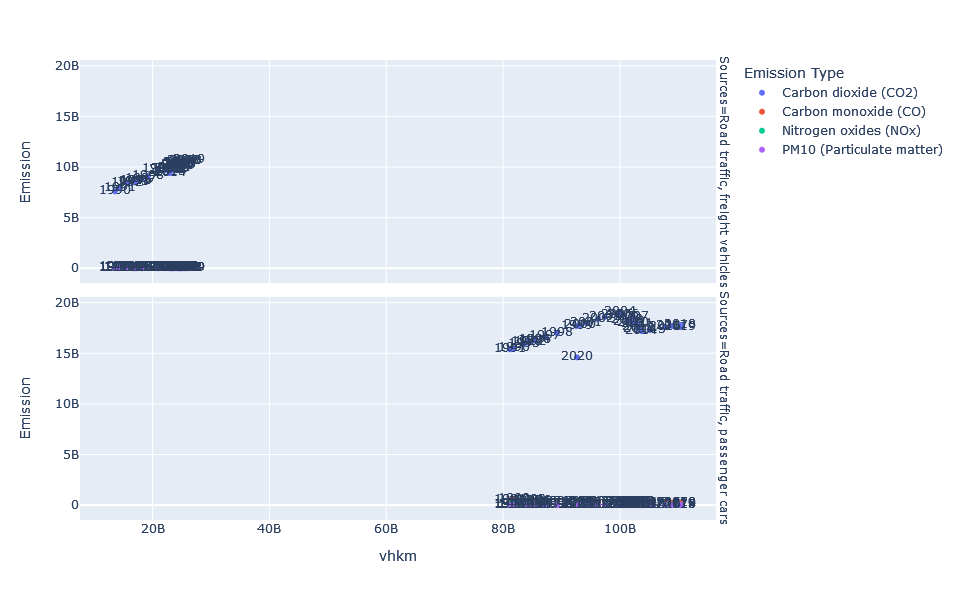

In [13]:
px.scatter(vehicle_data, x="vhkm", y="Emission", text="Year", color="Emission Type", facet_row="Sources", height=600)

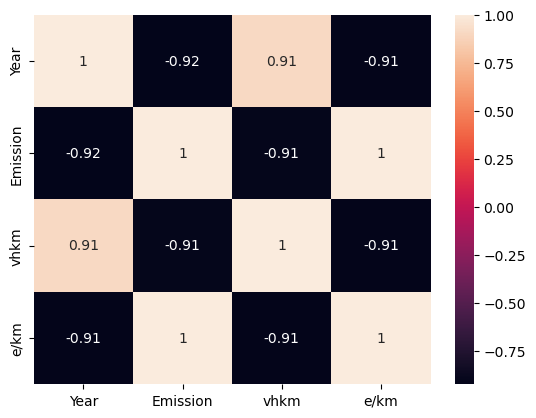

In [16]:
corr_heatmap("car", "NOx")

# Python code/functions

#### Load Data functions

In [4]:
def load_vk_data(data_path, meta_path):
    vk_data = pd.read_csv(data_path, sep=";", index_col="ID")
    vk_meta = pd.read_csv(meta_path, sep=";", skiprows=1, index_col="Key")

    vehicle_type = vk_data["TypesOfVehicle"].array.copy()
    for i in range(len(vehicle_type)):
        vehicle_type[i] = vk_meta.loc[vehicle_type[i], "Title"]

    vk_data["TypesOfVehicle"] = vehicle_type
    vk_data["Periods"] = vk_data["Periods"].apply(lambda s: int(s[0:4]))
    vk_data.drop(columns=vk_data.columns.to_list()[3:], inplace=True)
    vk_data.rename(columns={"TypesOfVehicle":"Vehicle Type", "Periods":"Year", "TotalKilometresInTheNetherlands_1":"vhkm"}, inplace=True)
    vk_data["vhkm"] *= 1000000 # stored in milion km
    return vk_data

def load_ems_data(data_path, source_meta_path, emissions_meta_path):
    ems_data = pd.read_csv(data_path, sep=";", index_col="ID")
    ems_source_meta = pd.read_csv(source_meta_path, sep=";", skiprows=1, index_col="Key")
    ems_emission_meta = pd.read_csv(emissions_meta_path, sep=";", skiprows=1, index_col="Key")

    sources = ems_data["Sources"].array.copy()
    emissions = ems_data["Emissions"].array.copy()
    for i in range(len(sources)):
        sources[i] = ems_source_meta.loc[sources[i], "Title"]
        emissions[i] = ems_emission_meta.loc[emissions[i], "Title"]

    ems_data["Sources"] = sources
    ems_data["Emissions"] = emissions
    ems_data["Periods"] = ems_data["Periods"].apply(lambda s: int(s[0:4]))
    ems_data.rename(columns={"Emissions":"Emission Type", "Periods":"Year", "EmissionsDutchTerritory_1":"Emission"}, inplace=True)
    ems_data["Emission"] *= 1000000 # stored in milion kg
    return ems_data

# print(vk_data["Vehicle Type"].unique())
# print()
# print(ems_data["Sources"].unique())
# print()
# print(ems_data["Emission Type"].unique())

#### Filter Data functions

In [5]:
def getCategory(df, col_name, cat, sum_cat):
    df = df.copy()
    bools = np.zeros(len(df[col_name]), dtype=bool)
    
    for i in range(len(cat)):
        bools = np.logical_or(bools, df[col_name] == cat[i])
        
    if sum_cat:
        df = df[bools].groupby("Year").sum()
        df["Year"] = df.index.array
        df.index.names = ["Not_Year"]
        return df
    else:
        return df[bools]

#### Heatmaps

In [6]:
def corr_heatmap(vehicle, emission, start_year=1990, end_year=2021):
    vehicle_data_CO2 = vehicle_data[vehicle_data["Emission Type"] == "Carbon dioxide (CO2)"]
    vehicle_data_CO = vehicle_data[vehicle_data["Emission Type"] == "Carbon monoxide (CO)"]
    vehicle_data_NOx = vehicle_data[vehicle_data["Emission Type"] == "Nitrogen oxides (NOx)"]
    vehicle_data_PM10 = vehicle_data[vehicle_data["Emission Type"] == "PM10 (Particulate matter)"]

    vehicle_data_CO2 = vehicle_data_CO2[vehicle_data_CO2["Year"] >= start_year]
    vehicle_data_CO2 = vehicle_data_CO2[vehicle_data_CO2["Year"] <= end_year]
    vehicle_data_CO = vehicle_data_CO[vehicle_data_CO["Year"] >= start_year]
    vehicle_data_CO = vehicle_data_CO[vehicle_data_CO["Year"] <= end_year]
    vehicle_data_NOx = vehicle_data_NOx[vehicle_data_NOx["Year"] >= start_year]
    vehicle_data_NOx = vehicle_data_NOx[vehicle_data_NOx["Year"] <= end_year]
    vehicle_data_PM10 = vehicle_data_PM10[vehicle_data_PM10["Year"] >= start_year]
    vehicle_data_PM10 = vehicle_data_PM10[vehicle_data_PM10["Year"] <= end_year]

    car_data_CO2 = vehicle_data_CO2[vehicle_data_CO2["Sources"] == "Road traffic, passenger cars"]
    car_data_CO = vehicle_data_CO[vehicle_data_CO["Sources"] == "Road traffic, passenger cars"]
    car_data_NOx = vehicle_data_NOx[vehicle_data_NOx["Sources"] == "Road traffic, passenger cars"]
    car_data_PM10 = vehicle_data_PM10[vehicle_data_PM10["Sources"] == "Road traffic, passenger cars"]
    freight_data_CO2 = vehicle_data_CO2[vehicle_data_CO2["Sources"] == "Road traffic, freight vehicles"]
    freight_data_CO = vehicle_data_CO[vehicle_data_CO["Sources"] == "Road traffic, freight vehicles"]
    freight_data_NOx = vehicle_data_NOx[vehicle_data_NOx["Sources"] == "Road traffic, freight vehicles"]
    freight_data_PM10 = vehicle_data_PM10[vehicle_data_PM10["Sources"] == "Road traffic, freight vehicles"]
    
    sns.heatmap(eval(f"{vehicle}_data_{emission}").corr(method="pearson"), annot=True)